In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [3]:
%matplotlib inline

import pandas as pd
from aeps import AEP_metrics_lims
from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from loading import load_session_data
from target import get_spike_counts
from statsmodels.formula.api import ols, glm
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from spiketrain import inst_rate
from population import unit_response_matrix, spontaneous_activity

np.set_printoptions(suppress=True)

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [79]:
dst_path = "/home/sobolev/nevermind/AG_Pecka/data/processed/"
rep_path = '/home/sobolev/nevermind/Andrey/analysis/reporting'

sessions = [s for s in selected_009266.keys()]
sessions.sort()
sessions[:2]

['009266_hippoSIT_2023-04-17_17-04-17', '009266_hippoSIT_2023-04-18_10-10-37']

## Single session - pop activity and PSTH

In [80]:
session = sessions[-4]
session

'009266_hippoSIT_2023-05-23_09-18-05'

In [81]:
dst_path = "/home/sobolev/nevermind/AG_Pecka/data/processed/"

animal   = session.split('_')[0]
meta_file  = os.path.join(dst_path, animal, session, 'meta.h5')
units_file = os.path.join(dst_path, animal, session, 'units.h5')
aeps_file  = os.path.join(dst_path, animal, session, 'AEPs.h5')

with h5py.File(meta_file, 'r') as f:
    sound_events = np.array(f['processed']['sound_events'])
    tgt_mx       = np.array(f['processed']['target_matrix'])
    tl           = np.array(f['processed']['timeline'])

aeps = {}
with h5py.File(aeps_file, 'r') as f:
    for area in f:
        ds_name = [x for x in f[area]][0]
        aeps[area] = np.array(f[area][ds_name])
        
single_units, spike_times = {}, {}
with h5py.File(units_file, 'r') as f:
    unit_names = [x for x in f]
with h5py.File(units_file, 'r') as f:
    for unit_name in unit_names:
        spike_times[unit_name]  = np.array(f[unit_name][H5NAMES.spike_times['name']])
        single_units[unit_name] = np.array(f[unit_name][H5NAMES.inst_rate['name']])

titles = ['Noi', 'Sil', 'Bgr', 'Tgt']
for i, p in enumerate([-1, 0, 1, 2]):
    print("%s: %d" % (titles[i], len(sound_events[sound_events[:, 1] == p])))

Noi: 353
Sil: 3619
Bgr: 4820
Tgt: 807


In [82]:
# # compute population activity
# spike_times_A1 = dict([(name, spk_times) for name, spk_times in spike_times.items() if int(name[0]) < 3])
# unit_mx, pop_act = pop_activity_score(tl[:, 0], spike_times_A1)

# if stats.pearsonr(pop_act, unit_mx.mean(axis=1))[0] < 0:
#     pop_act = (-1)*pop_act
    
# # filter very low oscillations 
# # maybe it's a result? check if it's because of badly sorted spike clusters
# s_rate, low_cut, high_cut = 100, 0.01, 10  # Hz
# sos = signal.butter(10, [low_cut / (0.5*s_rate), high_cut/(0.5*s_rate)], analog=False, btype='band', output='sos')
# pop_act_filt = signal.sosfiltfilt(sos, pop_act)

s_path = os.path.join(dst_path, animal, session)
pop_act  = spontaneous_activity(s_path)

sos = signal.butter(10, 0.01, fs=4, analog=False, btype='highpass', output='sos')
pop_act_filt = signal.sosfiltfilt(sos, pop_act)
pop_act_filt.shape

(9599,)

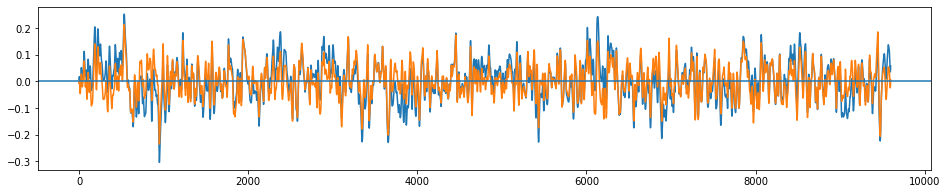

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(16, 3))
ax.plot(pop_act)
ax.plot(pop_act_filt)
#ax.set_xlim(0, 250000)
ax.axhline(0)

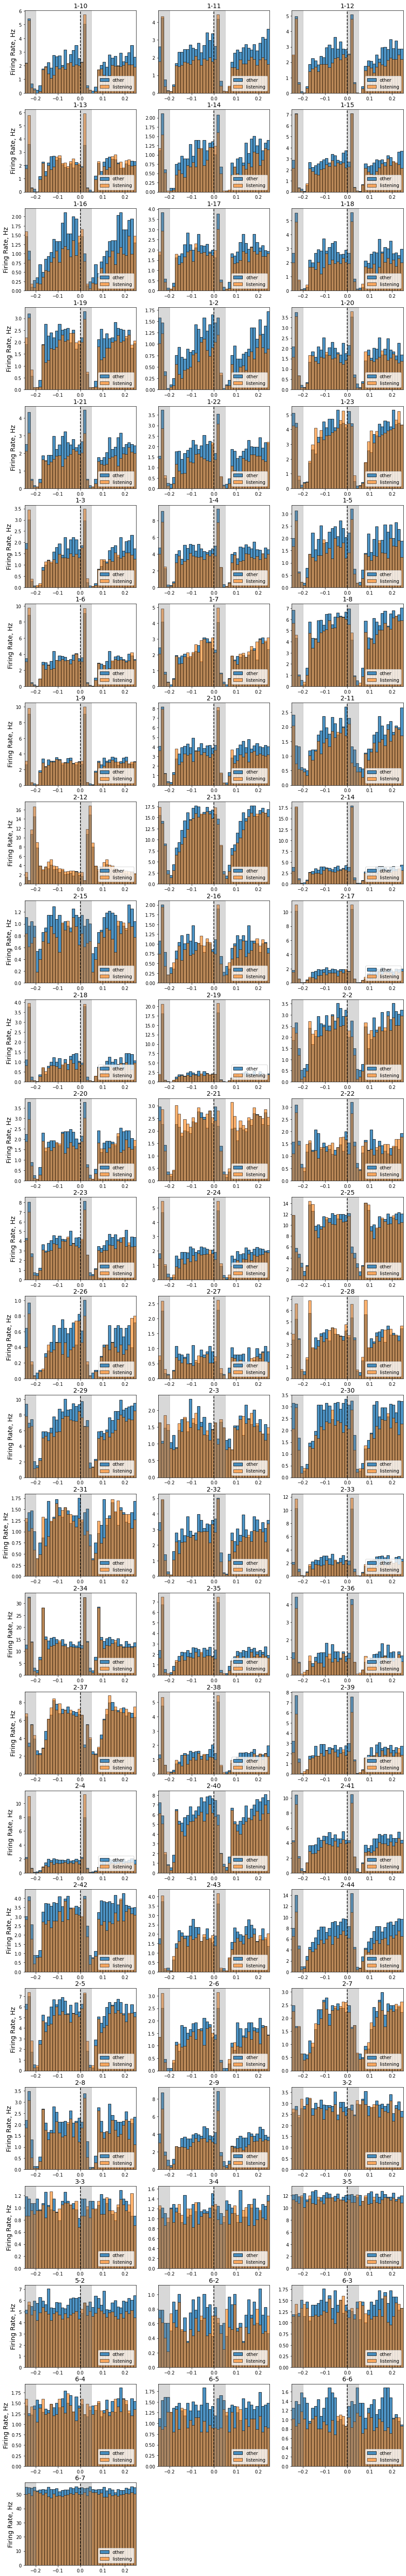

In [84]:
pop_mean  = pop_act_filt.mean()
idxs_bgr  = np.where(sound_events[:, 1] == 1)[0]
idxs_high = np.where(pop_act_filt > pop_mean)[0]
idxs_low  = np.where(pop_act_filt < pop_mean)[0]

psth_times_high = sound_events[np.intersect1d(idxs_bgr, idxs_high)][:, 0]
psth_times_low  = sound_events[np.intersect1d(idxs_bgr, idxs_low)][:, 0]
to_plot = unit_names

hw, bc = 0.25, 41
cols = 3
rows = int(np.ceil(len(to_plot)/3))
fig = plt.figure(figsize=(15, rows*4))

for i, unit_name in enumerate(to_plot[:]):
    bins, counts_A = get_spike_counts(spike_times[unit_name], psth_times_high, hw, bc)
    bins, counts_B = get_spike_counts(spike_times[unit_name], psth_times_low, hw, bc)
    
    ax = fig.add_subplot(rows, cols, i+1)
    
    ax.hist(bins[:-1], bins=bins, weights=counts_A, edgecolor='black', color='tab:blue', alpha=0.8, label='other')
    ax.hist(bins[:-1], bins=bins, weights=counts_B, edgecolor='black', color='tab:orange', alpha=0.6, label='listening')
    ax.axvline(0, color='black', ls='--')
    ax.axvspan(0, 0.05, alpha=0.3, color='gray')
    ax.axvspan(0 - hw, 0 - hw + 0.05, alpha=0.3, color='gray')
    ax.set_title(unit_name, fontsize=14)
    ax.legend(loc='lower right', prop={'size': 10})
    ax.set_xlim(-hw, hw)
    if i % 3 == 0:
        ax.set_ylabel("Firing Rate, Hz", fontsize=14)

In [85]:
fig.savefig(os.path.join(rep_path, '%s_PSTH_high_low.pdf' % session))

Text(0.5, 0, 'Time, ms')

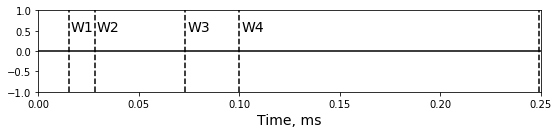

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(9, 1.5))
ax.axhline(0, color='black')

for i, lims in enumerate(AEP_metrics_lims['A1'].values()):
    ax.axvline(lims[0]/1000, ls='--', color='black')
    ax.text(lims[0]/1000 + 0.001, 0.5, 'W%s' % str(i+1), fontsize=14)
ax.axvline(0.249, ls='--', color='black')
ax.set_xlim(0, 0.25)
ax.set_ylim(-1, 1)
ax.set_xlabel('Time, ms', fontsize=14)


#ax.hist(bins[:-1], bins=bins, weights=counts_A, edgecolor='black', color='tab:blue', alpha=0.8)